<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/Statistical_Models_0722.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### # 통계 (ARIMA) 모델 : 단기 데이터에 유리, 선형 학습 기반  (예측 시간 길어질수록 오차 증가)
1. AR (Autoregressive, 자기회귀) 과 MA (moving average) 를 합친 모델 (현재 시점의 상태를 파악하는 과거 시점의 자기 자신과 추세까지 전부 반영)
2. 차분을 통해 non-stationary한 상황에서 예측 하는 것 목표

ADF Statistic : -0.2851474434072275
p-value : 0.927581716132439
# Lags Used : 34
# Observations : 8605
Critical Value (1%): -3.431110168715755
Critical Value (5%): -2.8618759433562184
Critical Value (10%): -2.5669488177150632
비정상 시계열

ADF Statistic : -18.865497057448852
p-value : 0.0
# Lags Used : 33
# Observations : 8605
Critical Value (1%): -3.431110168715755
Critical Value (5%): -2.8618759433562184
Critical Value (10%): -2.5669488177150632
정상



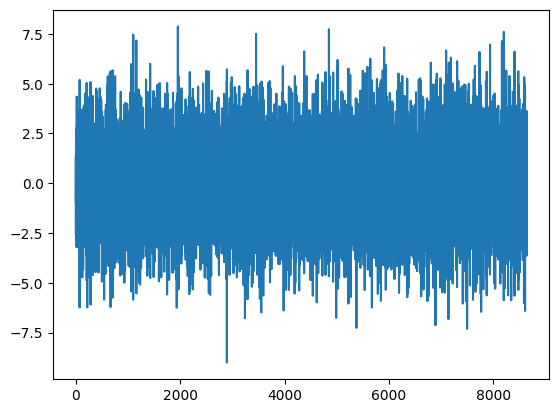

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

np.random.seed(42)
days = 30
points_per_day = 24*12
total_points = days * points_per_day
# cpu = 50 + 20*np.sin(np.linspace(0, 15, total_points))
cpu = 50 + 20*np.sin(np.linspace(0, 15, total_points)) + np.random.normal(0, 1.5, total_points)
df = pd.DataFrame({'CPU rate': np.clip(cpu,0,100)})


# train/ test
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)
train_data = df['CPU rate'][:split_idx]
test_data = df['CPU rate'][split_idx:]

# ADF 검정
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value,label in zip(result[:4], labels):
        print(f"{label} : {value}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    if result[1] <= 0.05:
        print("정상")
    else:
        print("비정상 시계열")
    print()


# 1. 원본 train_data 정상성 검정
adf_test(df, title='Original Train Data')

# 2. 1차 차분 후 정상성 검정
diff_series = df.diff().dropna()
adf_test(diff_series, title='1st Difference')
plt.plot(diff_series)
plt.show()

# 차분에서 정상 -> d = 1로 모델 피팅 (p,1,q)

# 3. 2차 차분
# diff_series_re = diff_series.diff().dropna()
# adf_test(diff_series_re, title='2st Difference')
# plt.plot(diff_series_re)
# plt.show()


In [4]:
# p,q 결정
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None

for p in range(0,4):
    for q in range(0,4):
        try:
            model = ARIMA(train_data, order=(p,1,q))
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic  # aic 가장 작게 하는 조합으로 선택
                best_order = (p,1,q)
        except:
            continue

print("Best order:", best_order, " AIC:", best_aic)


Best order: (2, 1, 3)  AIC: 25421.908743424094


                               SARIMAX Results                                
Dep. Variable:               CPU rate   No. Observations:                 6912
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -12704.423
Date:                Wed, 23 Jul 2025   AIC                          25422.846
Time:                        04:30:54   BIC                          25470.733
Sample:                             0   HQIC                         25439.358
                               - 6912                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0142      0.030     -0.476      0.634      -0.073       0.044
ar.L2          0.9996      0.026     37.744      0.000       0.948       1.051
ar.L3          0.0138      0.012      1.104      0.2

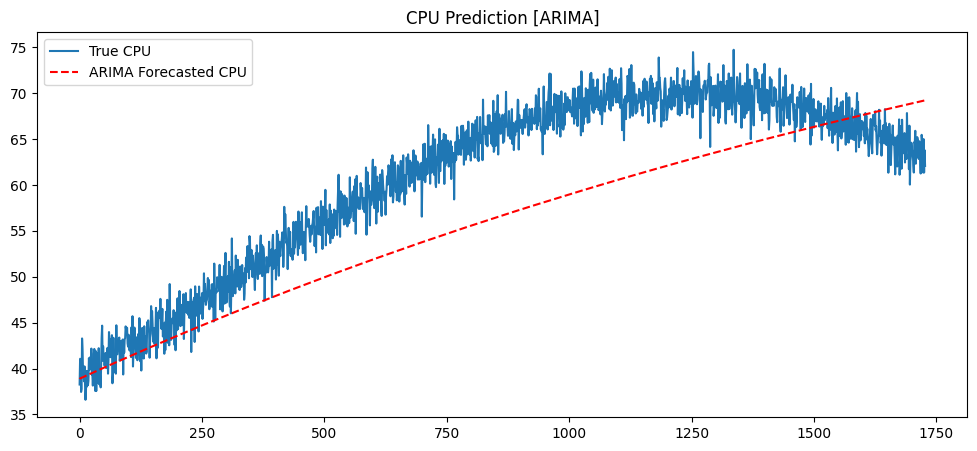

In [5]:
# p : 이전 관측값을 몇 개를 쓸 것인지? q: 이전 오차 값은 몇 개를 쓸 것인지? d: 정상성 만족을 위해 차분을 얼마나 하는지
model = ARIMA(train_data, order= (p,1,q))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test_data)) # train data를 이용해서 test data 길이만큼 예측
forecast = np.array(forecast) # 넘파이로 변환해서 0부터 인덱스 가능

rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae  = mean_absolute_error(test_data, forecast)
eps = 1e-6
mape = np.mean(np.abs((test_data - forecast) / (test_data + eps))) * 100
r2 = r2_score(test_data, forecast)

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")


plt.figure(figsize=(12,5))
plt.plot(test_data.values, label="True CPU")
plt.plot(forecast, label="ARIMA Forecasted CPU", linestyle='--', color='red')
plt.legend()
plt.title("CPU Prediction [ARIMA]")
plt.show()


### Auto-ARIMA

1. 자동으로 (p,d,q) 값 정해준다.
2. AIC만 보는 것이 아니라 복합적인 척도로 결정

In [1]:
pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.1
    Uninstalling numpy-2.3.1:
      Successfully uninstalled numpy-2.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompat

In [6]:
from pmdarima import auto_arima

# Auto ARIMA
auto_model = auto_arima(
    train_data,
    start_p=0, max_p=4,   # AR 범위
    start_q=0, max_q=4,   # MA 범위
    d=None,
    seasonal=False,
    stepwise=True,
    trace=True
)

print("✅ Best ARIMA order:", auto_model.order)


forecast = auto_model.predict(n_periods=len(test_data))


rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae  = mean_absolute_error(test_data, forecast)
eps = 1e-6
mape = np.mean(np.abs((test_data - forecast) / (test_data + eps))) * 100
r2   = r2_score(test_data, forecast)

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(test_data.values, label="True CPU")
plt.plot(forecast, label="Auto ARIMA Forecast", linestyle='--', color='red')
plt.legend()
plt.title("Auto ARIMA CPU Usage Prediction")
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
pred = model_fit.predict(n_periods=len(test_data), return_conf_int=True)
np.asarray(pred[1])

plt.plot(test_data, label='Observed')
plt.plot(pred[0], 'r', label='Predicted')
plt.fill_between(test_data.index, pred[1][:,0], pred[1][:,1], color='gray',alpha=0.2)
plt.legend()
plt.show()
Colored